# Polymarket Book Event Analysis

This notebook analyzes Polymarket market events data, specifically focusing on 'book' event types.
We calculate the sum of the two lowest ask prices from each asset_id for each timestamp.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
import os

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define path to trading data
data_path = "/Users/jonathanmines/Documents/code/signal_drift_project/SignalDrift/data/"
pattern = "20250625*polymarket_market_events.csv"

# Get all polymarket market events files
files = glob.glob(os.path.join(data_path, pattern))
print(f"Found {len(files)} polymarket market events files:")
for file in files[:5]:  # Show first 5 files
    print(f"  - {os.path.basename(file)}")
if len(files) > 5:
    print(f"  ... and {len(files) - 5} more files")

Found 8 polymarket market events files:
  - 20250625-mlb-tor-cle-2025-06-25-polymarket_market_events.csv
  - 20250625-mlb-chc-stl-2025-06-25-polymarket_market_events.csv
  - 20250625-mlb-tb-kc-2025-06-25-polymarket_market_events.csv
  - 20250625-mlb-atl-nym-2025-06-25-polymarket_market_events.csv
  - 20250625-mlb-sea-min-2025-06-25-polymarket_market_events.csv
  ... and 3 more files


In [3]:
def load_and_filter_data(file_path):
    """
    Load a polymarket events CSV file and filter for book events with ask side.
    
    Returns:
        pd.DataFrame: Filtered dataframe with book events and ask side only
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Filter for book events and ask side only
        book_asks = df[(df['event_type'] == 'book') & (df['side'] == 'ask')].copy()
        
        # Convert timestamp to datetime for easier analysis
        book_asks['datetime'] = pd.to_datetime(book_asks['timestamp'], unit='ms')
        book_asks['timestamp_id'] = book_asks['timestamp']
        
        print(f"Loaded {len(df)} total rows, {len(book_asks)} book ask events from {os.path.basename(file_path)}")
        
        return book_asks
    
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return pd.DataFrame()

# Test with the first file
if files:
    test_data = load_and_filter_data(files[0])
    print(f"\nSample data structure:")
    print(test_data.head())
    print(f"\nUnique asset_ids: {test_data['asset_id'].nunique()}")
    print(f"Unique timestamps: {test_data['timestamp'].nunique()}")
    test_data

Loaded 37598 total rows, 7093 book ask events from 20250625-mlb-tor-cle-2025-06-25-polymarket_market_events.csv

Sample data structure:
              market_slug                                           asset_id  \
0  mlb-tor-cle-2025-06-25  1982014513810592928062467925311661466050635754...   
1  mlb-tor-cle-2025-06-25  1982014513810592928062467925311661466050635754...   
2  mlb-tor-cle-2025-06-25  1982014513810592928062467925311661466050635754...   
3  mlb-tor-cle-2025-06-25  1982014513810592928062467925311661466050635754...   
4  mlb-tor-cle-2025-06-25  1982014513810592928062467925311661466050635754...   

   market_id event_type  price side   size  \
0        NaN       book   0.99  ask  250.0   
1        NaN       book   0.98  ask  100.0   
2        NaN       book   0.97  ask   20.0   
3        NaN       book   0.96  ask   20.0   
4        NaN       book   0.95  ask   20.0   

                                       hash      timestamp  \
0  cab729cb2ef1df8f801e06707cc1ba5013fa0ea9 

In [4]:
def create_summary_object(group_df):
    """
    For each X group, create a summary object with:
    - sum_Y45_p: sum of minimum P values for Y=4 and Y=5
    - min_Y{value}_p: minimum P value for each Y group
    - min_Y{value}_N: N value corresponding to minimum P for each Y group
    """
    # Group by asset_id within this timestamp group and get the row with minimum price for each asset_id
    asset_groups = group_df.groupby('asset_id')
    min_p_rows = asset_groups.apply(lambda x: x.loc[x['price'].idxmin()], include_groups=False)
    
    result = {}
    
    # Get minimum P values for each Y group
    min_p_values = []
    for y_val, row in min_p_rows.iterrows():
        result['market_slug'] = row['market_slug']
        result['datetime'] = row['datetime']
        result['timestamp'] = row['timestamp']
        result[f'price_{y_val[-4:]}'] = row['price']
        result[f'size_{y_val[-4:]}'] = row['size']
        min_p_values.append(row['price'])

    result['price_sum'] = sum(min_p_values)
    return result

In [5]:
def get_lowest_ask_prices_by_timestamp(df):
    x = df.groupby('timestamp_id').apply(create_summary_object, include_groups=False)
    return pd.json_normalize(x)

a = get_lowest_ask_prices_by_timestamp(test_data)
a

,market_slug,datetime,timestamp,price_7107,size_7107,price_9657,size_9657,price_sum
0,mlb-tor-cle-2025-06-25,2025-06-25 22:02:52.617,1750888972617,0.49,65501.42,0.52,751.89,1.01
1,mlb-tor-cle-2025-06-25,2025-06-25 22:04:55.102,1750889095102,0.48,79248.11,0.53,53131.13,1.01
2,mlb-tor-cle-2025-06-25,2025-06-25 22:07:39.244,1750889259244,0.48,80358.32,0.53,20544.18,1.01
3,mlb-tor-cle-2025-06-25,2025-06-25 22:07:56.750,1750889276750,0.48,80358.32,0.53,16770.59,1.01
4,mlb-tor-cle-2025-06-25,2025-06-25 22:08:34.950,1750889314950,0.48,80299.88,0.53,16770.59,1.01
...,...,...,...,...,...,...,...,...
178,mlb-tor-cle-2025-06-25,2025-06-26 00:20:24.147,1750897224147,0.68,97.23,0.35,2742.98,1.03
179,mlb-tor-cle-2025-06-25,2025-06-26 00:20:25.239,1750897225239,0.68,97.23,0.35,2732.98,1.03
180,mlb-tor-cle-2025-06-25,2025-06-26 00:20:35.268,1750897235268,0.68,178.23,0.34,10.00,1.02
181,mlb-tor-cle-2025-06-25,2025-06-26 00:20:36.241,1750897236241,0.68,173.43,0.34,10.00,1.02


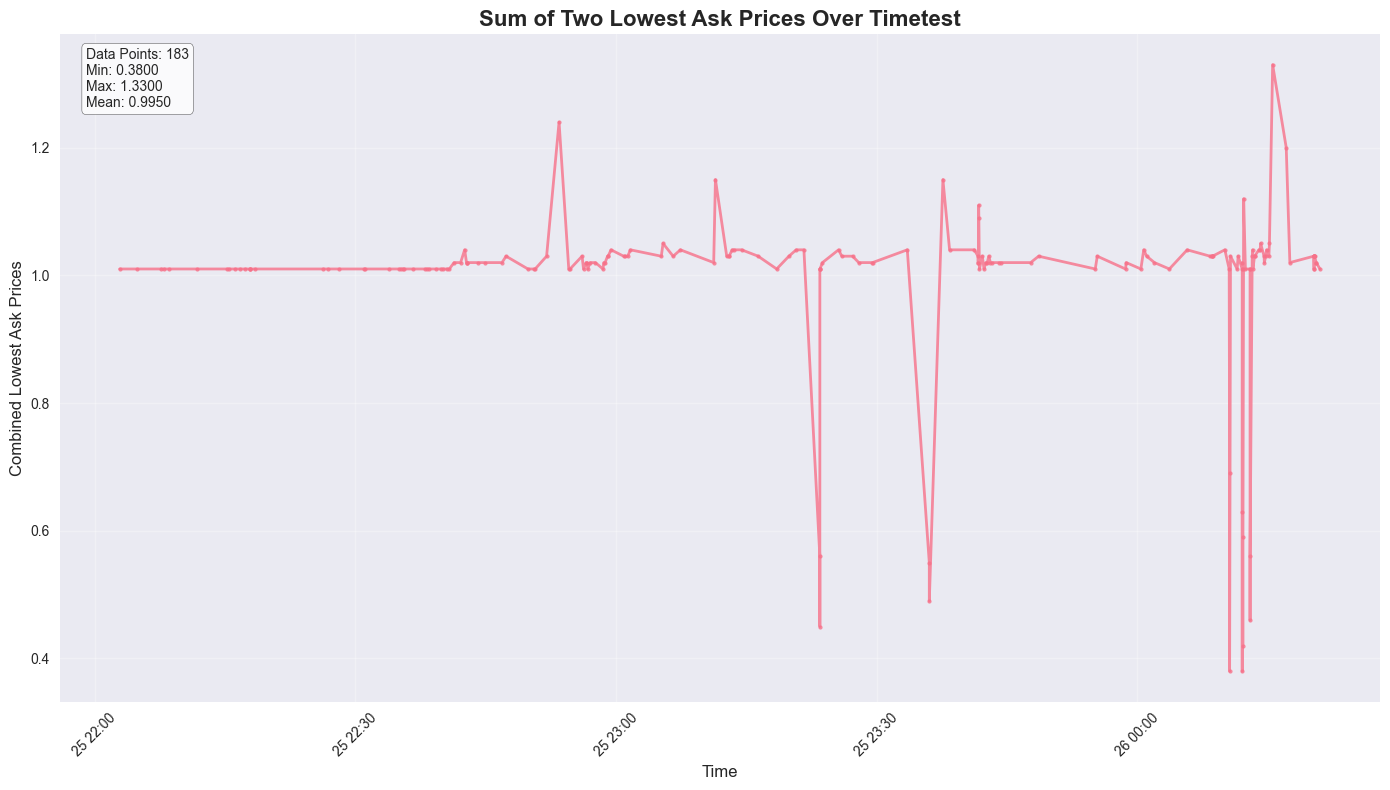

In [6]:
def create_visualization(result_df, title_suffix=""):
    """
    Create a line plot showing the combined lowest ask prices over time.
    
    Args:
        result_df: DataFrame with timestamp and combined_lowest_asks columns
        title_suffix: Additional text for the plot title
    """
    plt.figure(figsize=(14, 8))
    
    # Create the main plot
    plt.plot(result_df['datetime'], result_df['price_sum'], 
             linewidth=2, marker='o', markersize=3, alpha=0.8)
    
    plt.title(f'Sum of Two Lowest Ask Prices Over Time{title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Combined Lowest Ask Prices', fontsize=12)
    
    # Improve x-axis formatting
    plt.xticks(rotation=45)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    stats_text = f"""Data Points: {len(result_df)}
Min: {result_df['price_sum'].min():.4f}
Max: {result_df['price_sum'].max():.4f}
Mean: {result_df['price_sum'].mean():.4f}"""
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

create_visualization(a, "test")

In [7]:
def process_all_files(file_list, max_files=None):
    """
    Process multiple polymarket events files and combine results.
    
    Args:
        file_list: List of file paths to process
        max_files: Maximum number of files to process (None for all)
        
    Returns:
        dict: Dictionary with filename as key and result DataFrame as value
    """
    all_results = {}
    
    files_to_process = file_list[:max_files] if max_files else file_list
    
    for i, file_path in enumerate(files_to_process):
        print(f"Processing file {i+1}/{len(files_to_process)}: {os.path.basename(file_path)}")
        
        # Load and filter data
        book_data = load_and_filter_data(file_path)
        
        if not book_data.empty:
            # Calculate lowest ask prices
            result = get_lowest_ask_prices_by_timestamp(book_data)
            all_results[os.path.basename(file_path)] = result
            
            print(f"  -> Generated {len(result)} data points\n")
        else:
            print(f"  -> No valid data found\n")
    
    return all_results

# Process first 3 files as an example (you can change this number or remove the limit)
print("Processing multiple files...")
all_results = process_all_files(files, max_files=8)

print(f"\nProcessed {len(all_results)} files successfully:")
for filename, result_df in all_results.items():
    print(f"  - {filename}: {len(result_df)} data points")

Processing multiple files...
Processing file 1/8: 20250625-mlb-tor-cle-2025-06-25-polymarket_market_events.csv
Loaded 37598 total rows, 7093 book ask events from 20250625-mlb-tor-cle-2025-06-25-polymarket_market_events.csv
  -> Generated 183 data points

Processing file 2/8: 20250625-mlb-chc-stl-2025-06-25-polymarket_market_events.csv
Loaded 11309 total rows, 1305 book ask events from 20250625-mlb-chc-stl-2025-06-25-polymarket_market_events.csv
  -> Generated 64 data points

Processing file 3/8: 20250625-mlb-tb-kc-2025-06-25-polymarket_market_events.csv
Loaded 13906 total rows, 1521 book ask events from 20250625-mlb-tb-kc-2025-06-25-polymarket_market_events.csv
  -> Generated 72 data points

Processing file 4/8: 20250625-mlb-atl-nym-2025-06-25-polymarket_market_events.csv
Loaded 27017 total rows, 3877 book ask events from 20250625-mlb-atl-nym-2025-06-25-polymarket_market_events.csv
  -> Generated 117 data points

Processing file 5/8: 20250625-mlb-sea-min-2025-06-25-polymarket_market_ev


=== Visualization for 20250625-mlb-tor-cle-2025-06-25-polymarket_market_events.csv ===


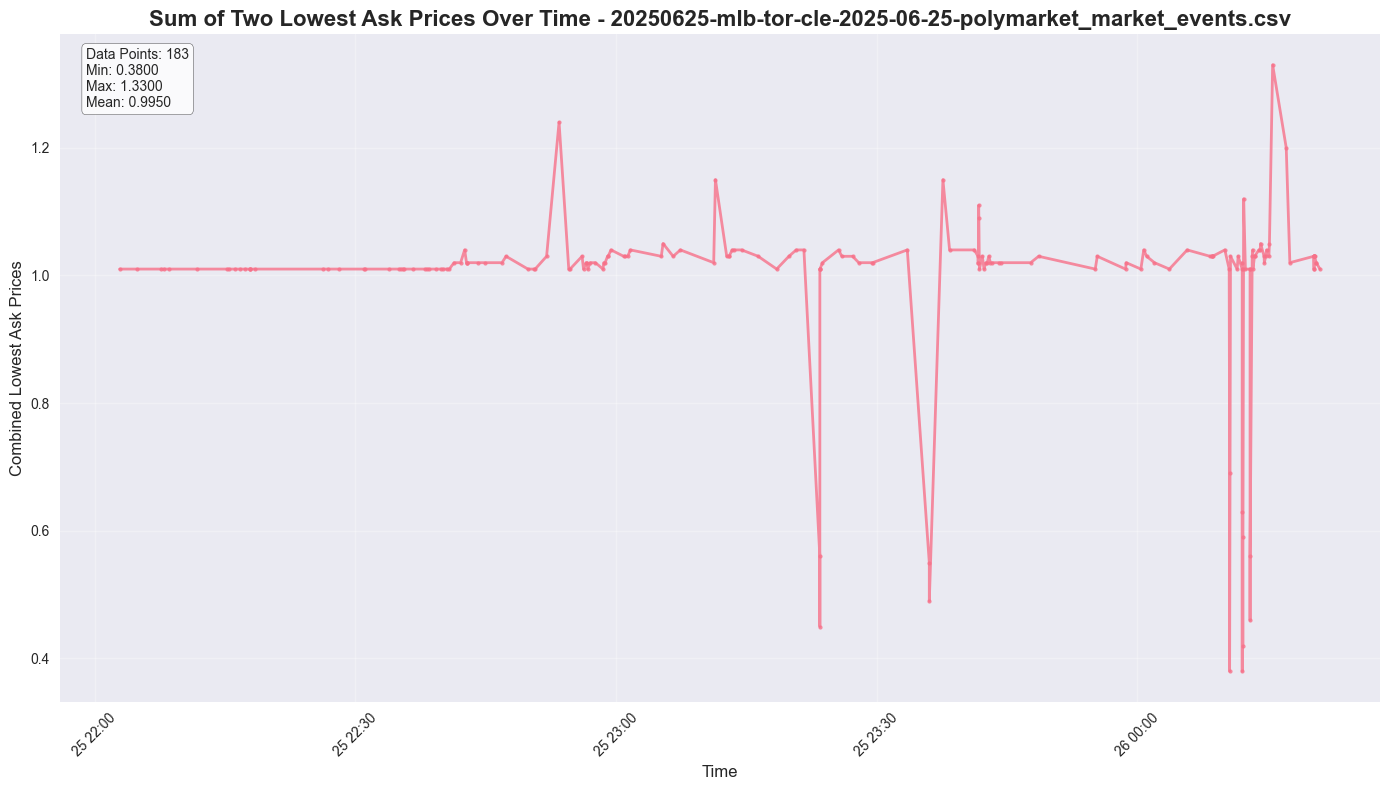


=== Visualization for 20250625-mlb-chc-stl-2025-06-25-polymarket_market_events.csv ===


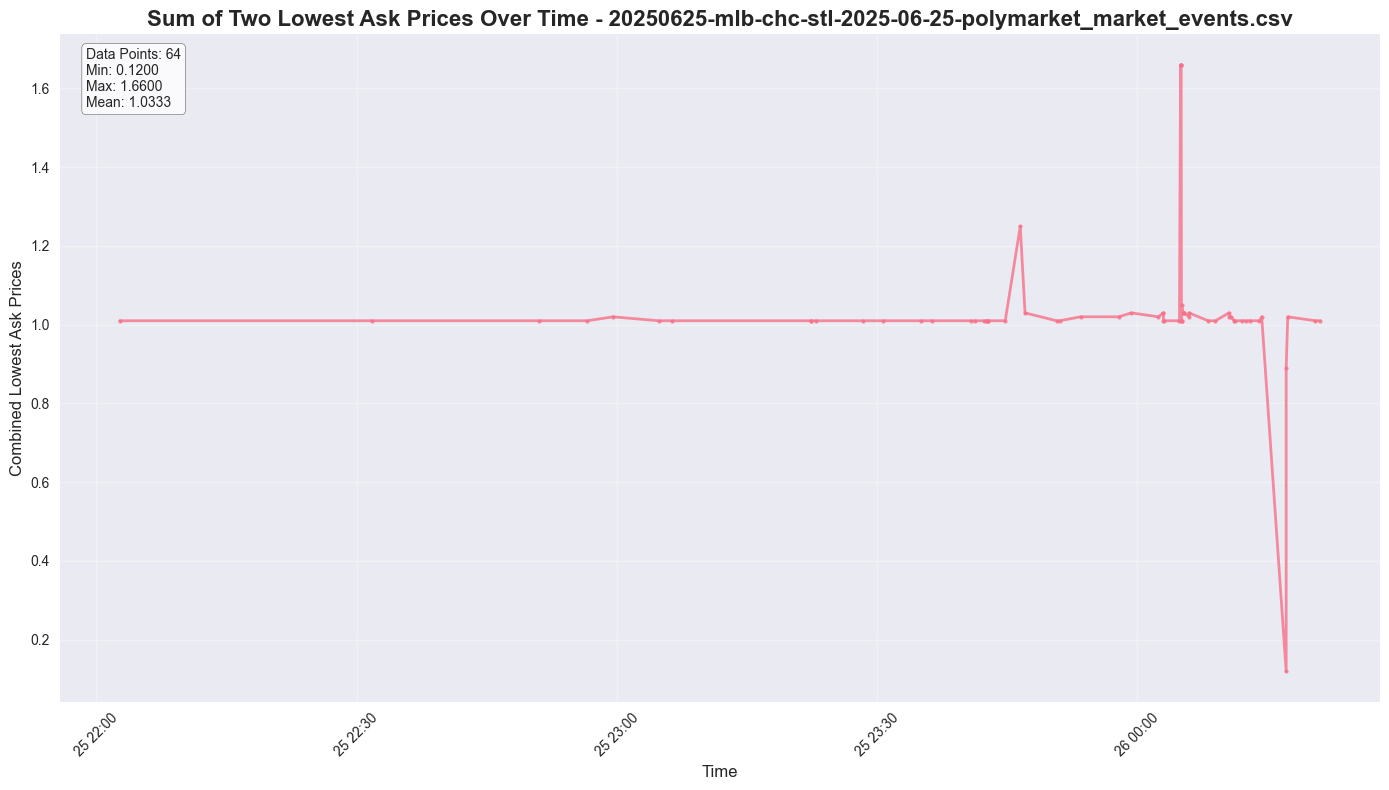


=== Visualization for 20250625-mlb-tb-kc-2025-06-25-polymarket_market_events.csv ===


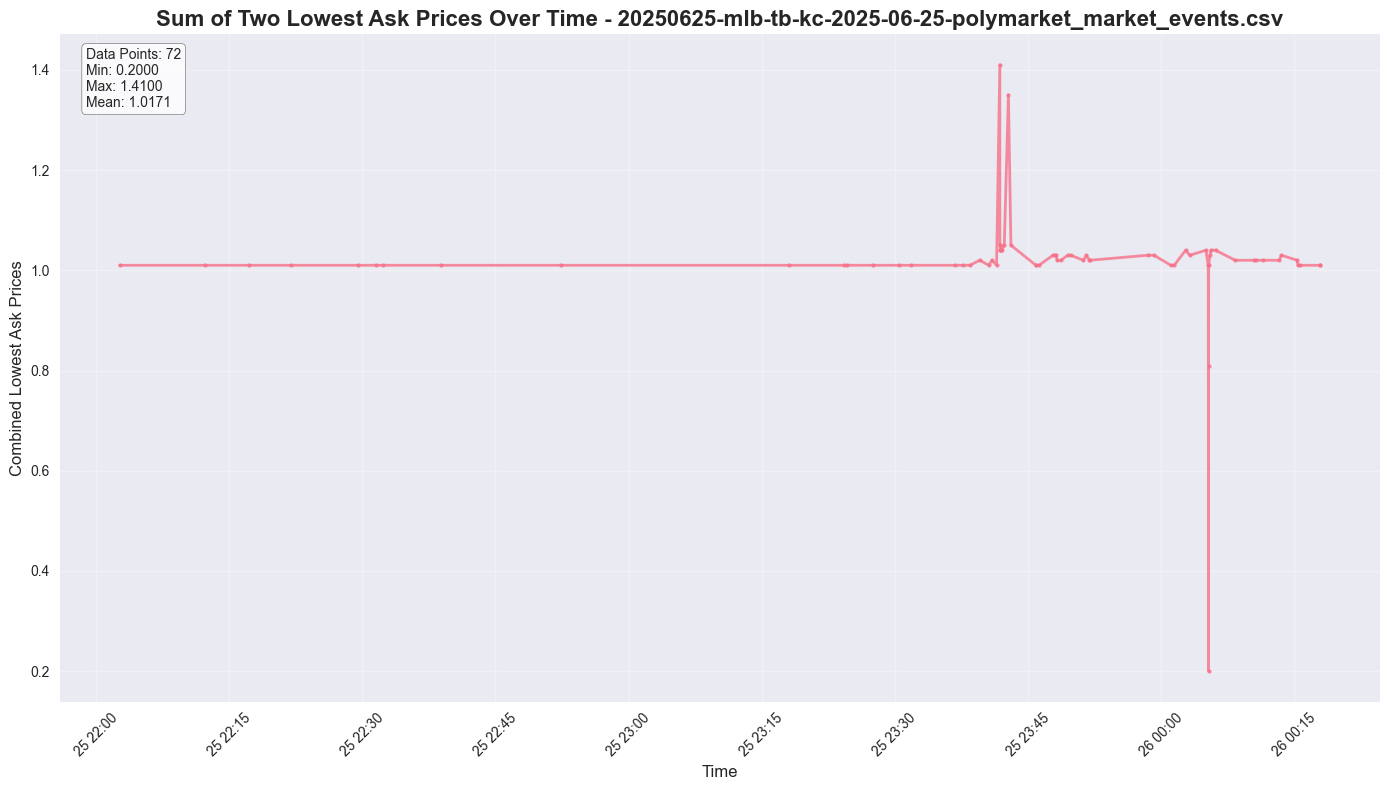


=== Visualization for 20250625-mlb-atl-nym-2025-06-25-polymarket_market_events.csv ===


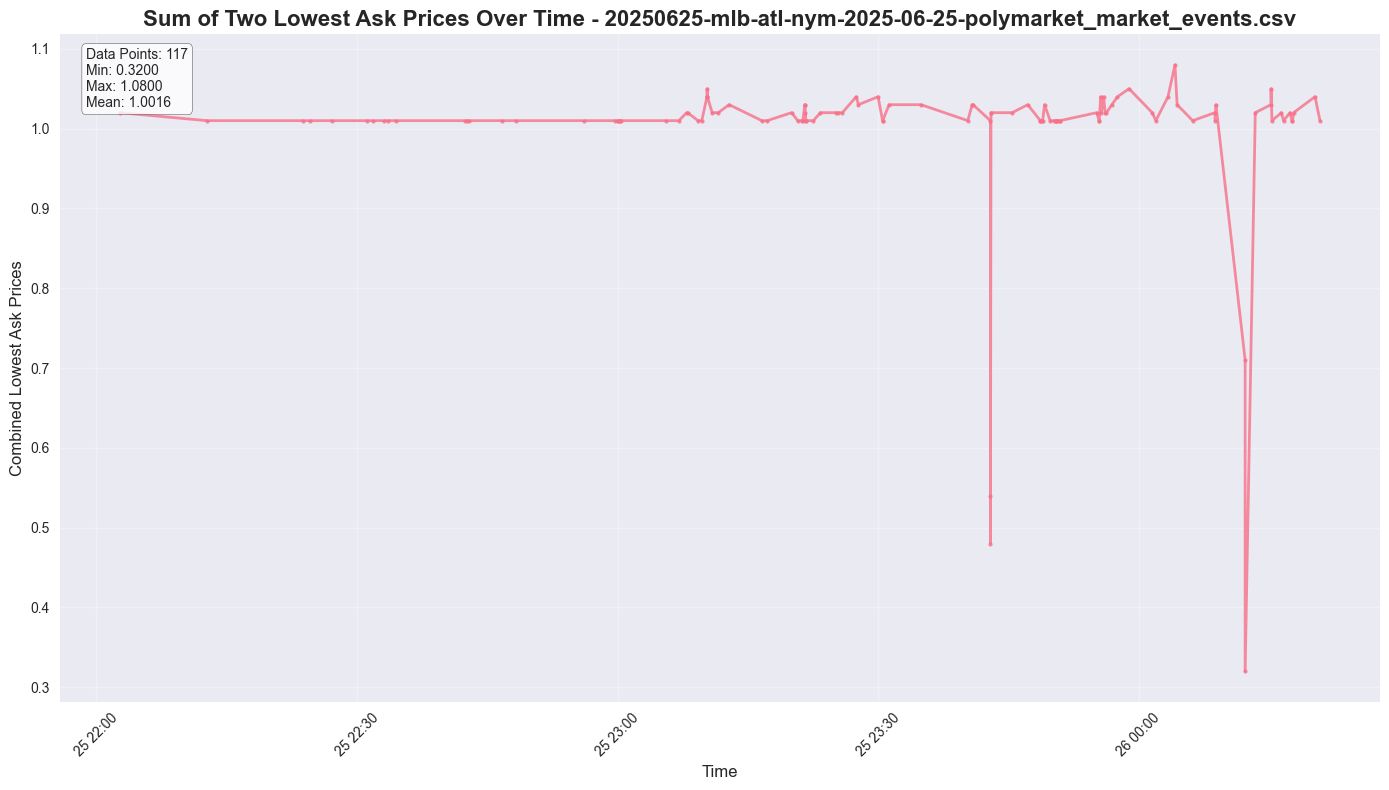


=== Visualization for 20250625-mlb-sea-min-2025-06-25-polymarket_market_events.csv ===


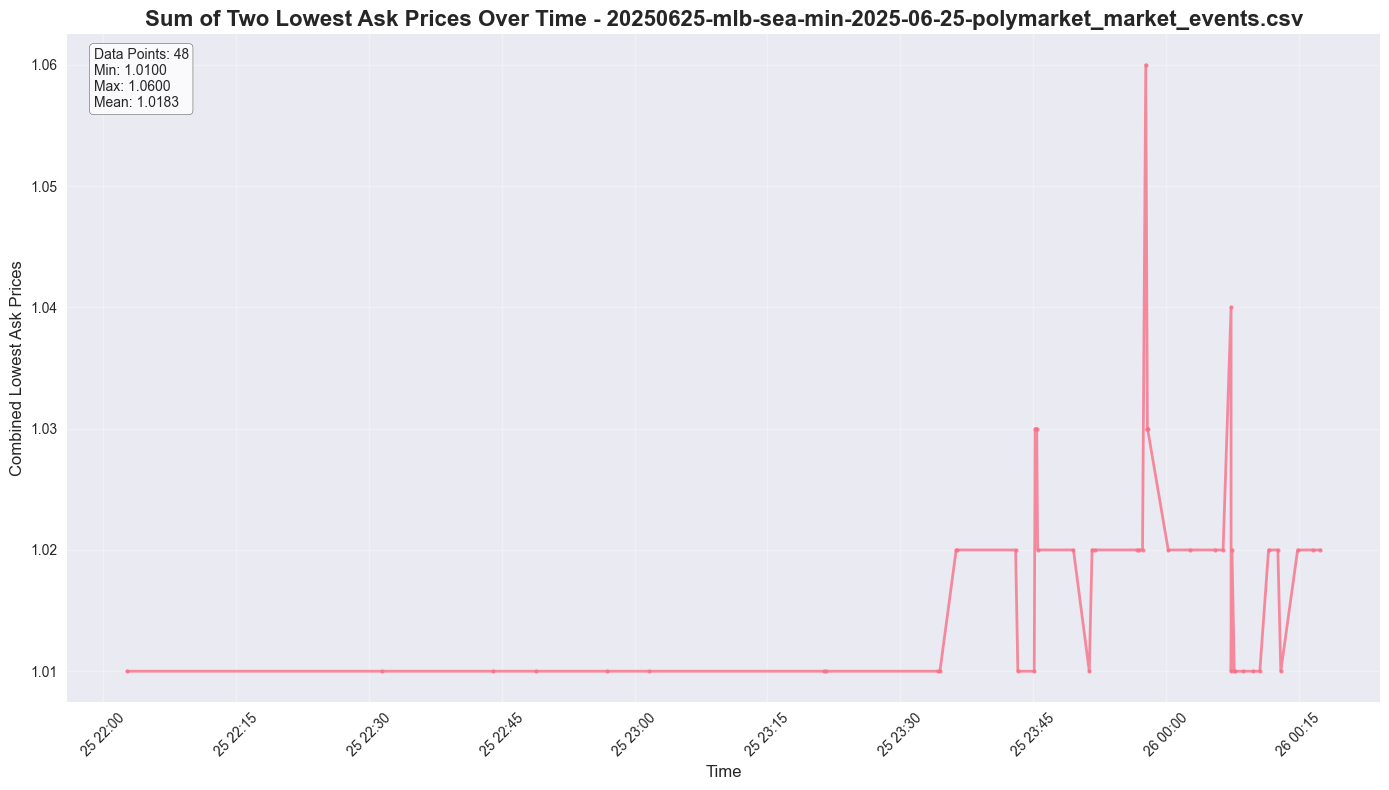


=== Visualization for 20250625-mlb-tex-bal-2025-06-25-polymarket_market_events.csv ===


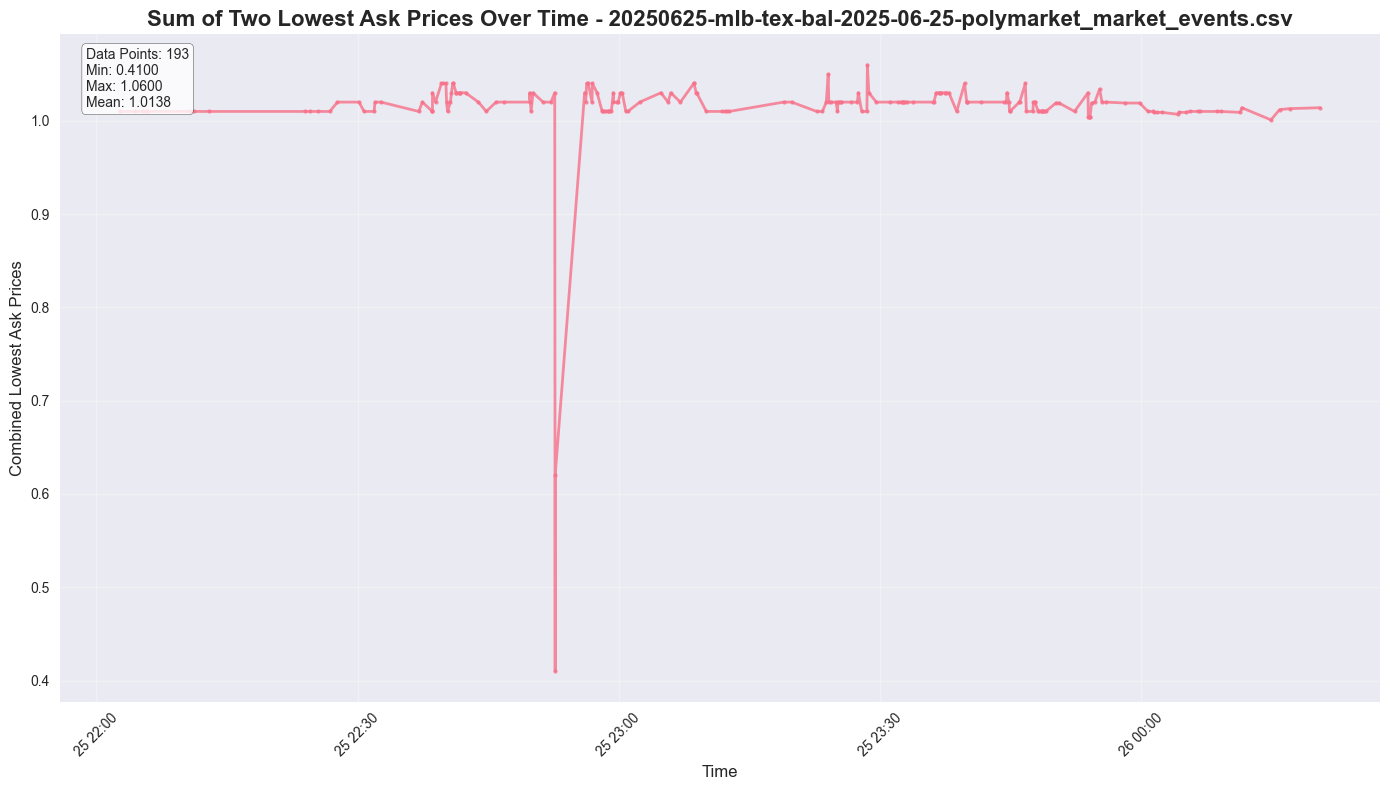


=== Visualization for 20250625-mlb-oak-det-2025-06-25-polymarket_market_events.csv ===


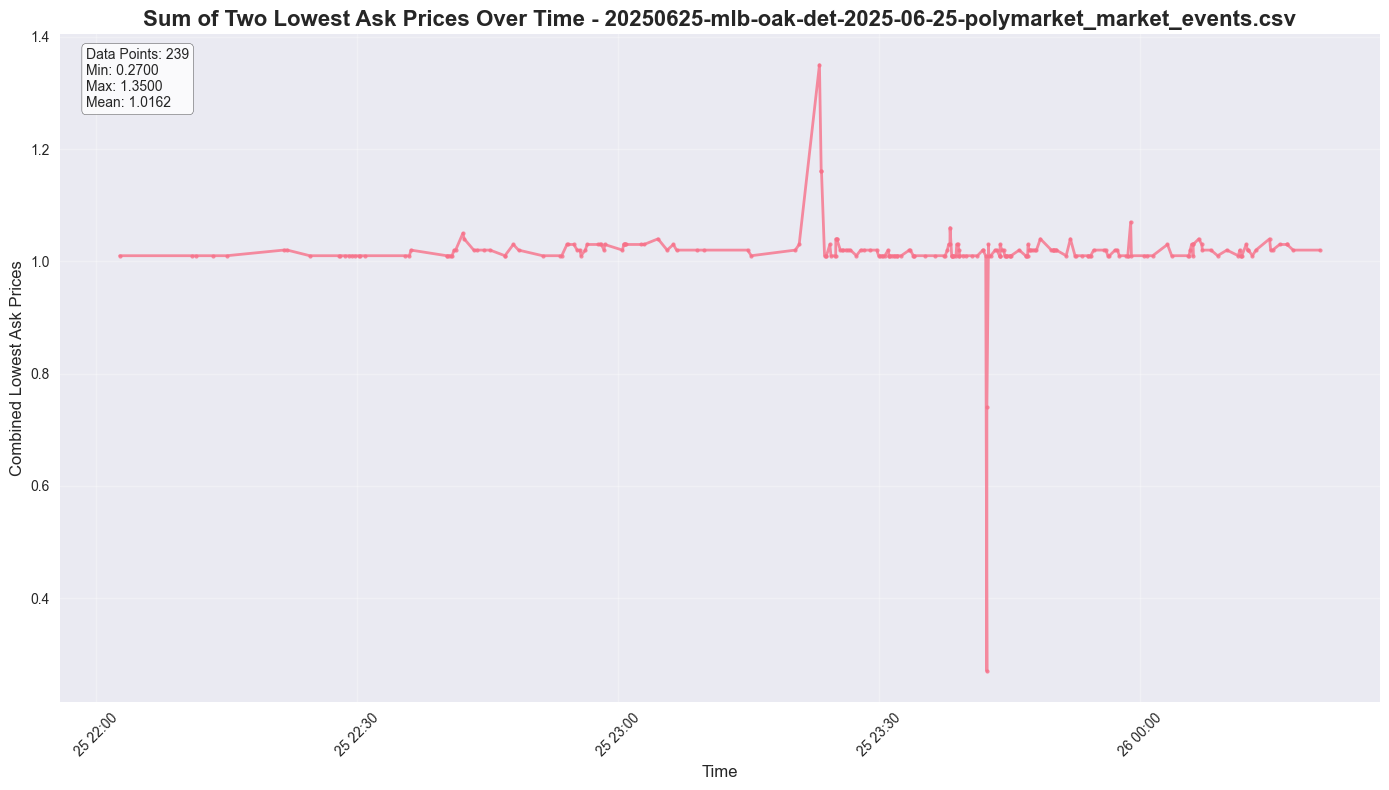


=== Visualization for 20250625-mlb-nyy-cin-2025-06-25-polymarket_market_events.csv ===


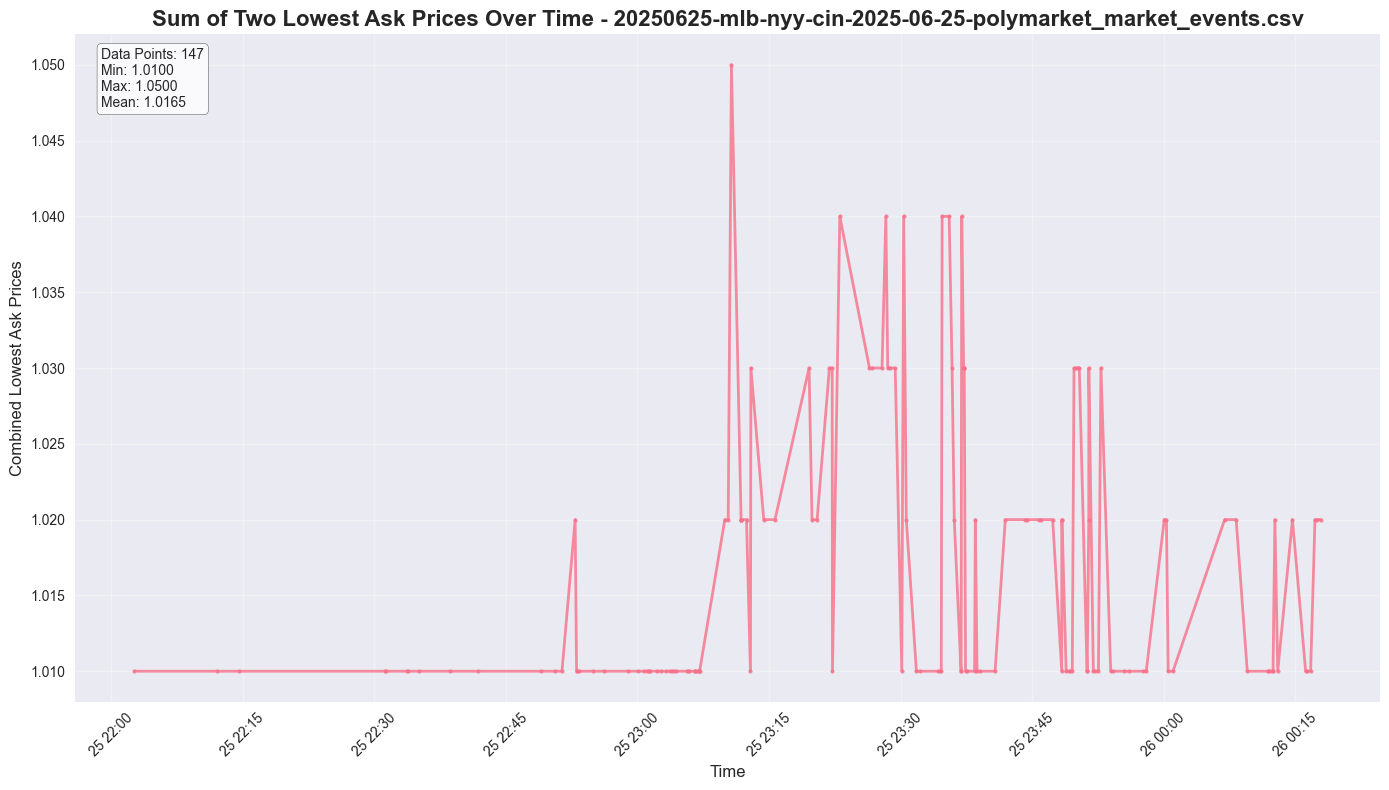

In [8]:
# Create individual plots for each file
for filename, result_df in all_results.items():
    if not result_df.empty:
        print(f"\n=== Visualization for {filename} ===")
        create_visualization(result_df, f" - {filename}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


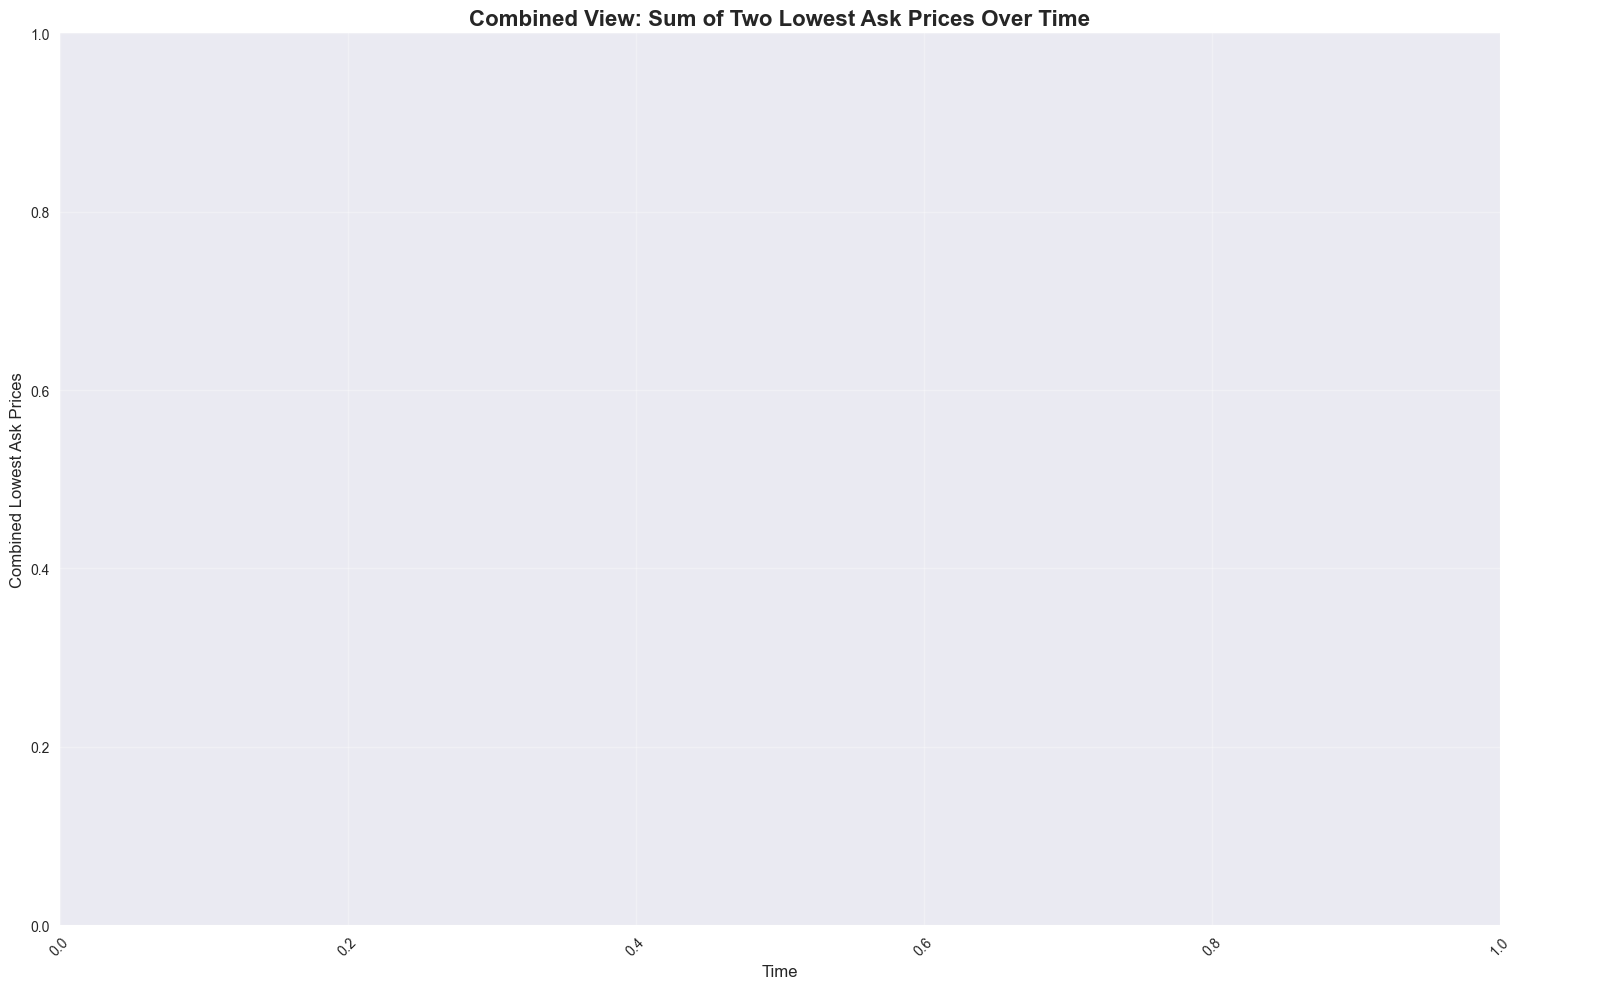


Combined visualization created!


In [9]:
# Optional: Combine all results into a single plot for comparison
if len(all_results) > 1:
    plt.figure(figsize=(16, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))
    
    for i, (filename, result_df) in enumerate(all_results.items()):
        if not result_df.empty and '20250619' in filename:
            plt.plot(result_df['datetime'], result_df['price_sum'], 
                    linewidth=2, marker='o', markersize=2, alpha=0.7, 
                    label=filename.replace('-polymarket_market_events.csv', ''), 
                    color=colors[i])
    
    plt.title('Combined View: Sum of Two Lowest Ask Prices Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Combined Lowest Ask Prices', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print("\nCombined visualization created!")

In [10]:
# Summary analysis
print("=== SUMMARY ANALYSIS ===")
print(f"Total files processed: {len(all_results)}")

all_stats = []
for filename, result_df in all_results.items():
    if not result_df.empty:
        stats = {
            'filename': filename,
            'data_points': len(result_df),
            'min_price': result_df['price_sum'].min(),
            'max_price': result_df['price_sum'].max(),
            'mean_price': result_df['price_sum'].mean(),
            'std_price': result_df['price_sum'].std(),
        }
        all_stats.append(stats)

if all_stats:
    summary_df = pd.DataFrame(all_stats)
    print("\nSummary Statistics:")
    print(summary_df.to_string(index=False, float_format='%.4f'))
    
    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"Total data points across all files: {summary_df['data_points'].sum()}")
    print(f"Average data points per file: {summary_df['data_points'].mean():.1f}")
else:
    print("No valid data found in any files.")

=== SUMMARY ANALYSIS ===
Total files processed: 8

Summary Statistics:
                                                    filename  data_points  min_price  max_price  mean_price  std_price
20250625-mlb-tor-cle-2025-06-25-polymarket_market_events.csv          183     0.3800     1.3300      0.9950     0.1353
20250625-mlb-chc-stl-2025-06-25-polymarket_market_events.csv           64     0.1200     1.6600      1.0333     0.1827
  20250625-mlb-tb-kc-2025-06-25-polymarket_market_events.csv           72     0.2000     1.4100      1.0171     0.1180
20250625-mlb-atl-nym-2025-06-25-polymarket_market_events.csv          117     0.3200     1.0800      1.0016     0.0968
20250625-mlb-sea-min-2025-06-25-polymarket_market_events.csv           48     1.0100     1.0600      1.0183     0.0097
20250625-mlb-tex-bal-2025-06-25-polymarket_market_events.csv          193     0.4100     1.0600      1.0138     0.0532
20250625-mlb-oak-det-2025-06-25-polymarket_market_events.csv          239     0.2700     1.3500 

# Synthetic Order Book Analysis

Now we'll analyze the synthetic order book files (`...order_book.csv`) to identify arbitrage opportunities. 
This analysis should show more opportunities than the Market Events analysis above since we capture price changes more frequently.

In [11]:
# Get all synthetic order book files
order_book_pattern = "2025062*synthetic_orders.csv"
order_book_files = glob.glob(os.path.join(data_path, order_book_pattern))

print(f"Found {len(order_book_files)} synthetic order book files:")
for file in order_book_files[:5]:  # Show first 5 files
    print(f"  - {os.path.basename(file)}")
if len(order_book_files) > 5:
    print(f"  ... and {len(order_book_files) - 5} more files")

Found 23 synthetic order book files:
  - 20250625-mlb-oak-det-2025-06-25-synthetic_orders.csv
  - 20250624-mlb-tor-cle-2025-06-24-synthetic_orders.csv
  - 20250624-mlb-nyy-cin-2025-06-24-synthetic_orders.csv
  - 20250625-mlb-tb-kc-2025-06-25-synthetic_orders.csv
  - 20250624-mlb-atl-nym-2025-06-24-synthetic_orders.csv
  ... and 18 more files


In [12]:
def load_synthetic_order_book(file_path):
    """
    Load a synthetic order book CSV file and filter for ask side orders.
    
    Returns:
        pd.DataFrame: Filtered dataframe with ask side orders only
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Filter for ask side only
        ask_orders = df[df['side'] == 'ask'].copy()
        
        # Convert timestamp to datetime for easier analysis
        ask_orders['datetime'] = pd.to_datetime(ask_orders['timestamp'], unit='ms')
        ask_orders['timestamp_id'] = ask_orders['timestamp']
        
        print(f"Loaded {len(df)} total rows, {len(ask_orders)} ask orders from {os.path.basename(file_path)}")
        
        return ask_orders
    
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return pd.DataFrame()

# Test with the first file
if order_book_files:
    test_order_book = load_synthetic_order_book(order_book_files[0])
    print(f"\nSample synthetic order book data:")
    print(test_order_book.head())
    print(f"\nUnique asset_ids: {test_order_book['asset_id'].nunique()}")
    print(f"Unique timestamps: {test_order_book['timestamp'].nunique()}")
    print(f"Unique outcome_names: {test_order_book['outcome_name'].unique()}")

Loaded 237250 total rows, 237250 ask orders from 20250625-mlb-oak-det-2025-06-25-synthetic_orders.csv

Sample synthetic order book data:
              market_slug                                           asset_id  \
0  mlb-oak-det-2025-06-25  6459822089680472363965506737412827965637304947...   
1  mlb-oak-det-2025-06-25  6459822089680472363965506737412827965637304947...   
2  mlb-oak-det-2025-06-25  6459822089680472363965506737412827965637304947...   
3  mlb-oak-det-2025-06-25  6459822089680472363965506737412827965637304947...   
4  mlb-oak-det-2025-06-25  6459822089680472363965506737412827965637304947...   

   market_id outcome_name  price      size side      timestamp  \
0     555177    Athletics   0.38   3010.22  ask  1750888983380   
1     555177    Athletics   0.39  94865.79  ask  1750888983380   
2     555177    Athletics   0.40  84014.33  ask  1750888983380   
3     555177    Athletics   0.41  33752.00  ask  1750888983380   
4     555177    Athletics   0.42   5432.00  ask  175

In [13]:
def create_order_book_summary(group_df):
    """
    For each timestamp group, create a summary object with:
    - sum of minimum ask prices for each asset_id
    - minimum price and size for each asset
    """
    # Group by asset_id within this timestamp group and get the row with minimum price for each asset_id
    asset_groups = group_df.groupby('asset_id')
    min_p_rows = asset_groups.apply(lambda x: x.loc[x['price'].idxmin()], include_groups=False)
    
    result = {}
    
    # Get minimum price values for each asset
    min_p_values = []
    for asset_id, row in min_p_rows.iterrows():
        result['market_slug'] = row['market_slug']
        result['datetime'] = row['datetime']
        result['timestamp'] = row['timestamp']
        # Use last 4 characters of asset_id as identifier
        result[f'price_{asset_id[-4:]}'] = row['price']
        result[f'size_{asset_id[-4:]}'] = row['size']
        result[f'outcome_{asset_id[-4:]}'] = row['outcome_name']
        
        min_p_values.append(row['price'])

    result['price_sum'] = sum(min_p_values)
    return result

def get_synthetic_order_book_arb_opportunities(df):
    """Calculate arbitrage opportunities from synthetic order book data."""
    x = df.groupby('timestamp_id').apply(create_order_book_summary, include_groups=False)
    return pd.json_normalize(x)

# Test with first file
if order_book_files and not test_order_book.empty:
    order_book_arb = get_synthetic_order_book_arb_opportunities(test_order_book)
    print(f"Found {len(order_book_arb)} timestamp groups")
    print(f"\nSample arbitrage data:")
    print(order_book_arb.head())
    
    # Show opportunities where sum < 1
    opportunities = order_book_arb[order_book_arb['price_sum'] < 1.0]
    print(f"\nFound {len(opportunities)} arbitrage opportunities (sum < $1)")
    if not opportunities.empty:
        print(opportunities[['datetime', 'price_sum']].head())

Found 256 timestamp groups

Sample arbitrage data:
              market_slug                datetime      timestamp  price_0565  \
0  mlb-oak-det-2025-06-25 2025-06-25 22:03:03.380  1750888983380        0.63   
1  mlb-oak-det-2025-06-25 2025-06-25 22:11:00.629  1750889460629        0.63   
2  mlb-oak-det-2025-06-25 2025-06-25 22:11:24.956  1750889484956        0.63   
3  mlb-oak-det-2025-06-25 2025-06-25 22:13:22.382  1750889602382        0.63   
4  mlb-oak-det-2025-06-25 2025-06-25 22:15:00.516  1750889700516        0.63   

   size_0565 outcome_0565  price_4486  size_4486 outcome_4486  price_sum  
0    3921.73       Tigers        0.38    3010.22    Athletics       1.01  
1    3889.98       Tigers        0.38   53010.22    Athletics       1.01  
2    3889.98       Tigers        0.38   52910.22    Athletics       1.01  
3    3889.98       Tigers        0.38   44563.40    Athletics       1.01  
4    3545.14       Tigers        0.38   44550.24    Athletics       1.01  

Found 36 arbitrag

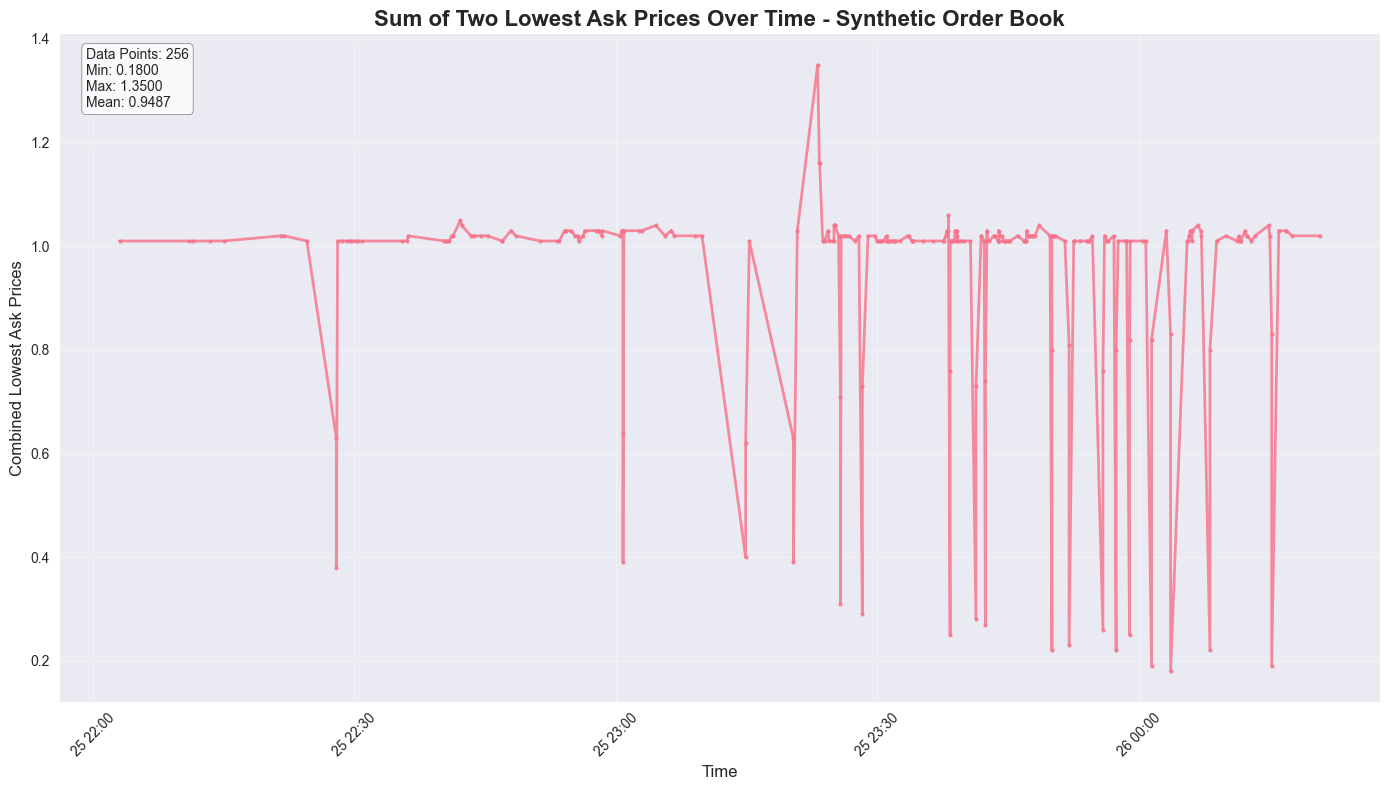

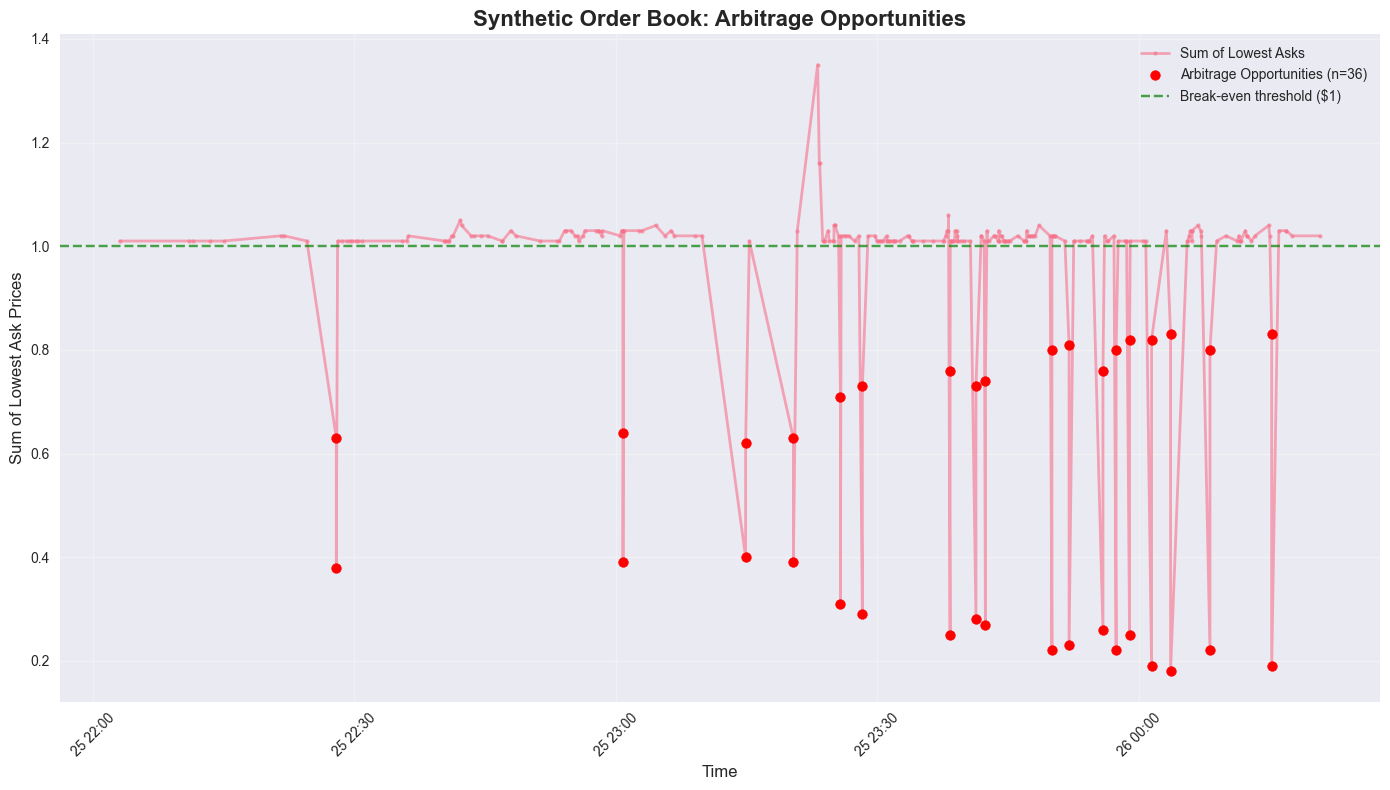

In [14]:
# Create visualization for synthetic order book data
if order_book_files and not test_order_book.empty:
    create_visualization(order_book_arb, " - Synthetic Order Book")
    
    # Highlight arbitrage opportunities
    plt.figure(figsize=(14, 8))
    
    # Plot all data points
    plt.plot(order_book_arb['datetime'], order_book_arb['price_sum'], 
             linewidth=2, marker='o', markersize=3, alpha=0.6, label='Sum of Lowest Asks')
    
    # Highlight opportunities (sum < 1.0) in red
    opportunities = order_book_arb[order_book_arb['price_sum'] < 1.0]
    if not opportunities.empty:
        plt.scatter(opportunities['datetime'], opportunities['price_sum'], 
                   color='red', s=50, zorder=5, label=f'Arbitrage Opportunities (n={len(opportunities)})')
    
    # Add horizontal line at y=1
    plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Break-even threshold ($1)')
    
    plt.title('Synthetic Order Book: Arbitrage Opportunities', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Sum of Lowest Ask Prices', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
def process_all_order_book_files(file_list, max_files=None):
    """
    Process multiple synthetic order book files and combine results.
    
    Args:
        file_list: List of file paths to process
        max_files: Maximum number of files to process (None for all)
        
    Returns:
        dict: Dictionary with filename as key and result DataFrame as value
    """
    all_results = {}
    
    files_to_process = file_list[:max_files] if max_files else file_list
    
    for i, file_path in enumerate(files_to_process):
        print(f"\nProcessing file {i+1}/{len(files_to_process)}: {os.path.basename(file_path)}")
        
        # Load and filter data
        order_book_data = load_synthetic_order_book(file_path)
        
        if not order_book_data.empty:
            # Calculate arbitrage opportunities
            result = get_synthetic_order_book_arb_opportunities(order_book_data)
            all_results[os.path.basename(file_path)] = result
            
            # Calculate statistics
            opportunities = result[result['price_sum'] < 1.0]
            
            print(opportunities[['market_slug', 'timestamp', 'price_sum']])
                
            print(f"  -> Generated {len(result)} data points")
            print(f"  -> Found {len(opportunities)} arbitrage opportunities ({len(opportunities)/len(result)*100:.1f}%)")
        else:
            print(f"  -> No valid data found")
    
    return all_results

# Process synthetic order book files
print("Processing synthetic order book files...")
order_book_results = process_all_order_book_files(order_book_files, max_files=8)

print(f"\n\nProcessed {len(order_book_results)} synthetic order book files successfully")

Processing synthetic order book files...

Processing file 1/8: 20250625-mlb-oak-det-2025-06-25-synthetic_orders.csv
Loaded 237250 total rows, 237250 ask orders from 20250625-mlb-oak-det-2025-06-25-synthetic_orders.csv
                market_slug      timestamp  price_sum
8    mlb-oak-det-2025-06-25  1750890474776       0.63
9    mlb-oak-det-2025-06-25  1750890474777       0.38
58   mlb-oak-det-2025-06-25  1750892448481       0.64
59   mlb-oak-det-2025-06-25  1750892448482       0.39
69   mlb-oak-det-2025-06-25  1750893292626       0.40
70   mlb-oak-det-2025-06-25  1750893292627       0.62
72   mlb-oak-det-2025-06-25  1750893621358       0.63
73   mlb-oak-det-2025-06-25  1750893621359       0.39
89   mlb-oak-det-2025-06-25  1750893945484       0.71
90   mlb-oak-det-2025-06-25  1750893945485       0.31
97   mlb-oak-det-2025-06-25  1750894096301       0.29
98   mlb-oak-det-2025-06-25  1750894096302       0.73
129  mlb-oak-det-2025-06-25  1750894700342       0.25
130  mlb-oak-det-2025-06-2


=== Visualization for 20250625-mlb-oak-det-2025-06-25-synthetic_orders.csv ===


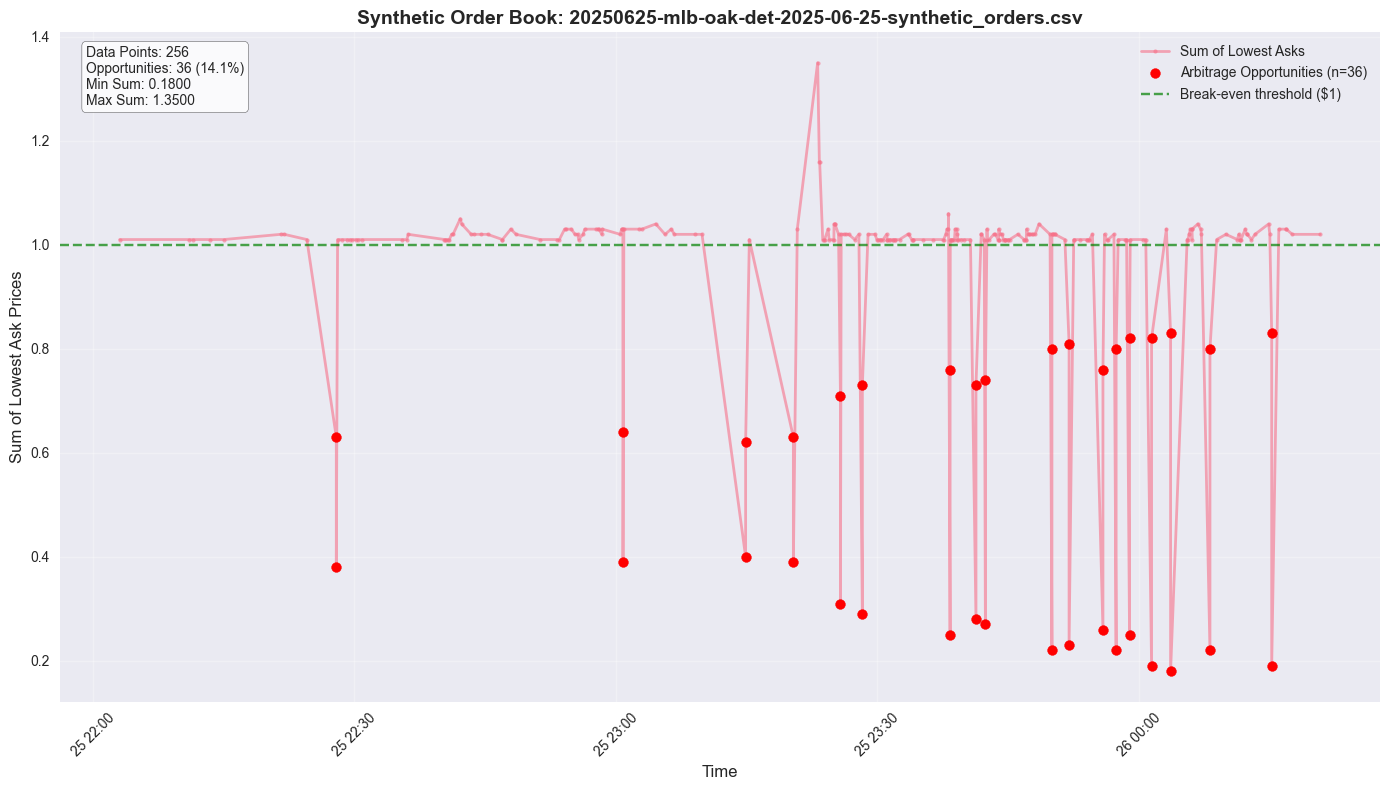


=== Visualization for 20250624-mlb-tor-cle-2025-06-24-synthetic_orders.csv ===


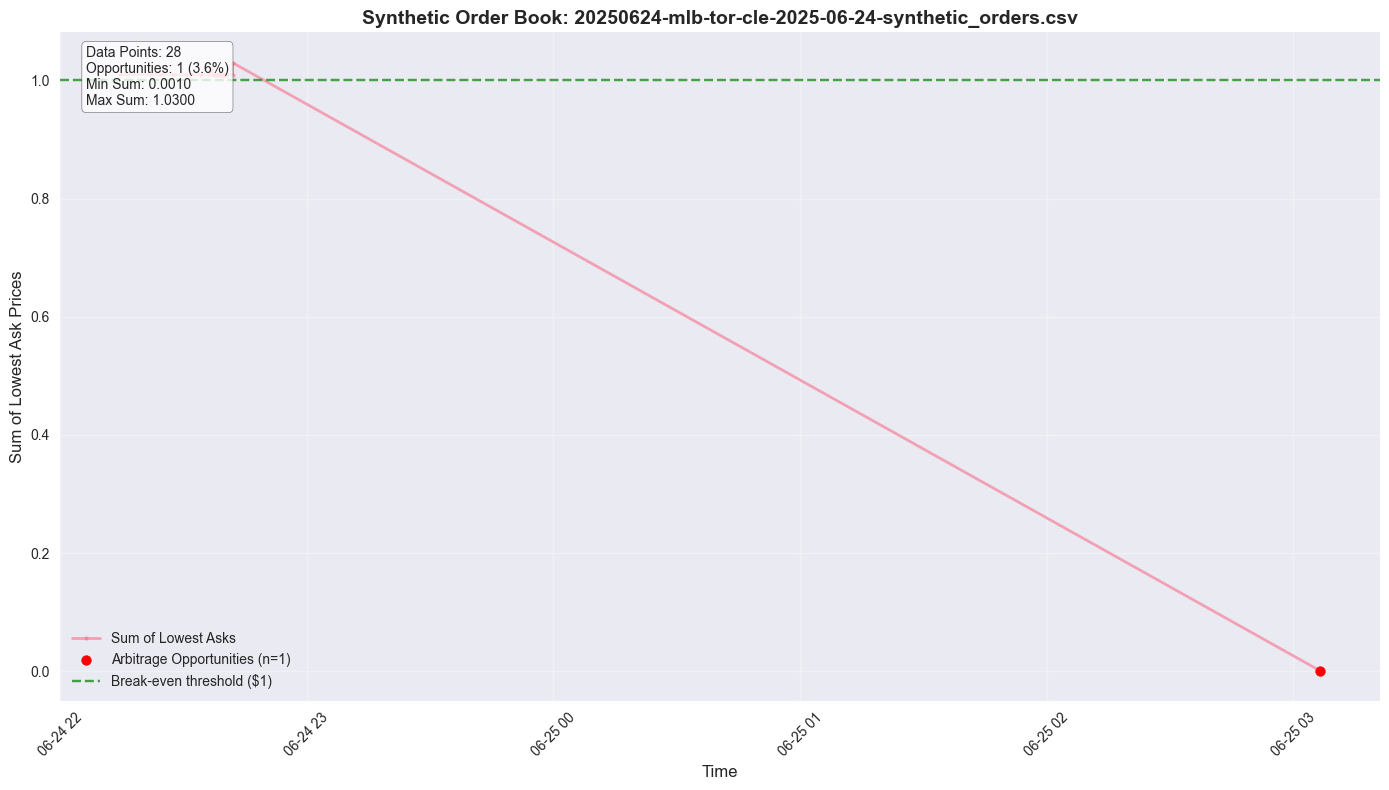


=== Visualization for 20250624-mlb-nyy-cin-2025-06-24-synthetic_orders.csv ===


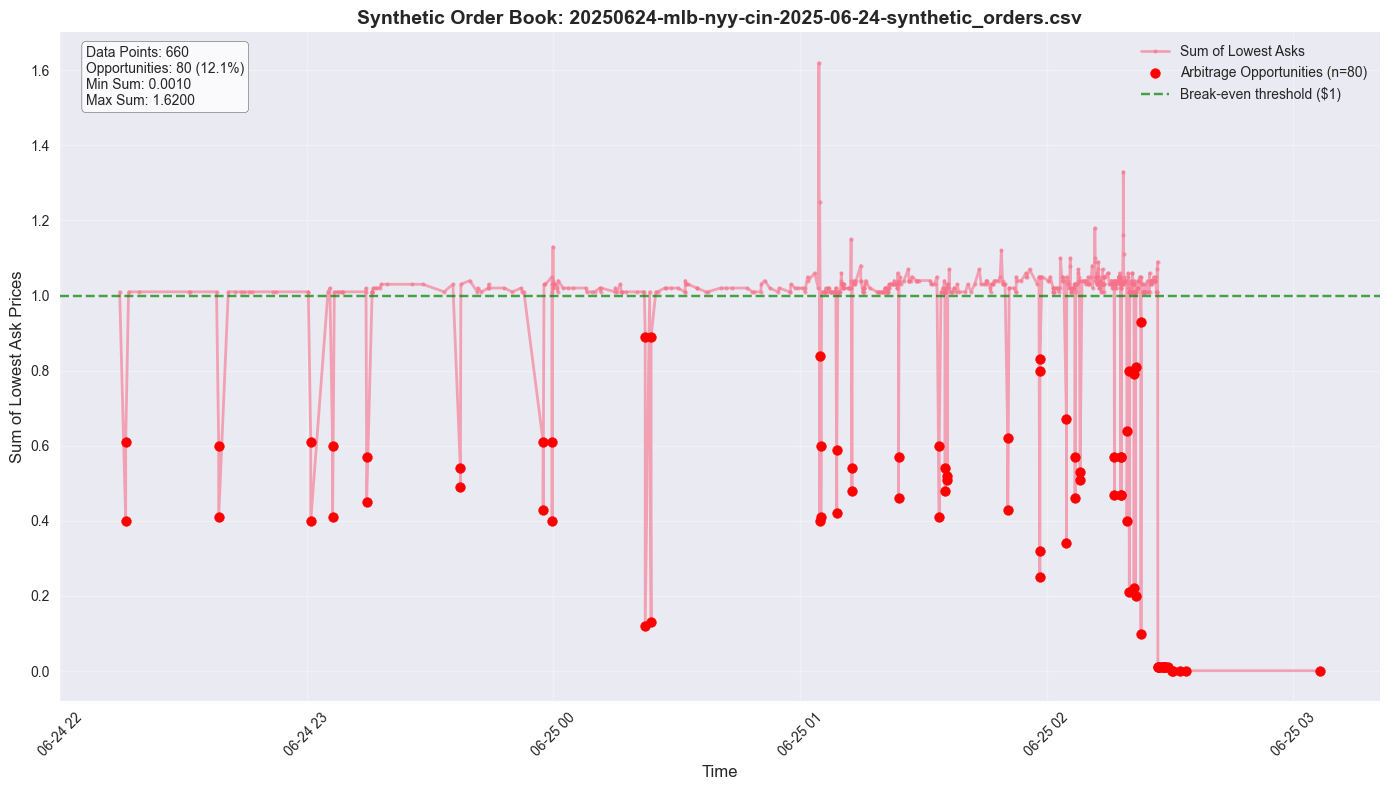


=== Visualization for 20250625-mlb-tb-kc-2025-06-25-synthetic_orders.csv ===


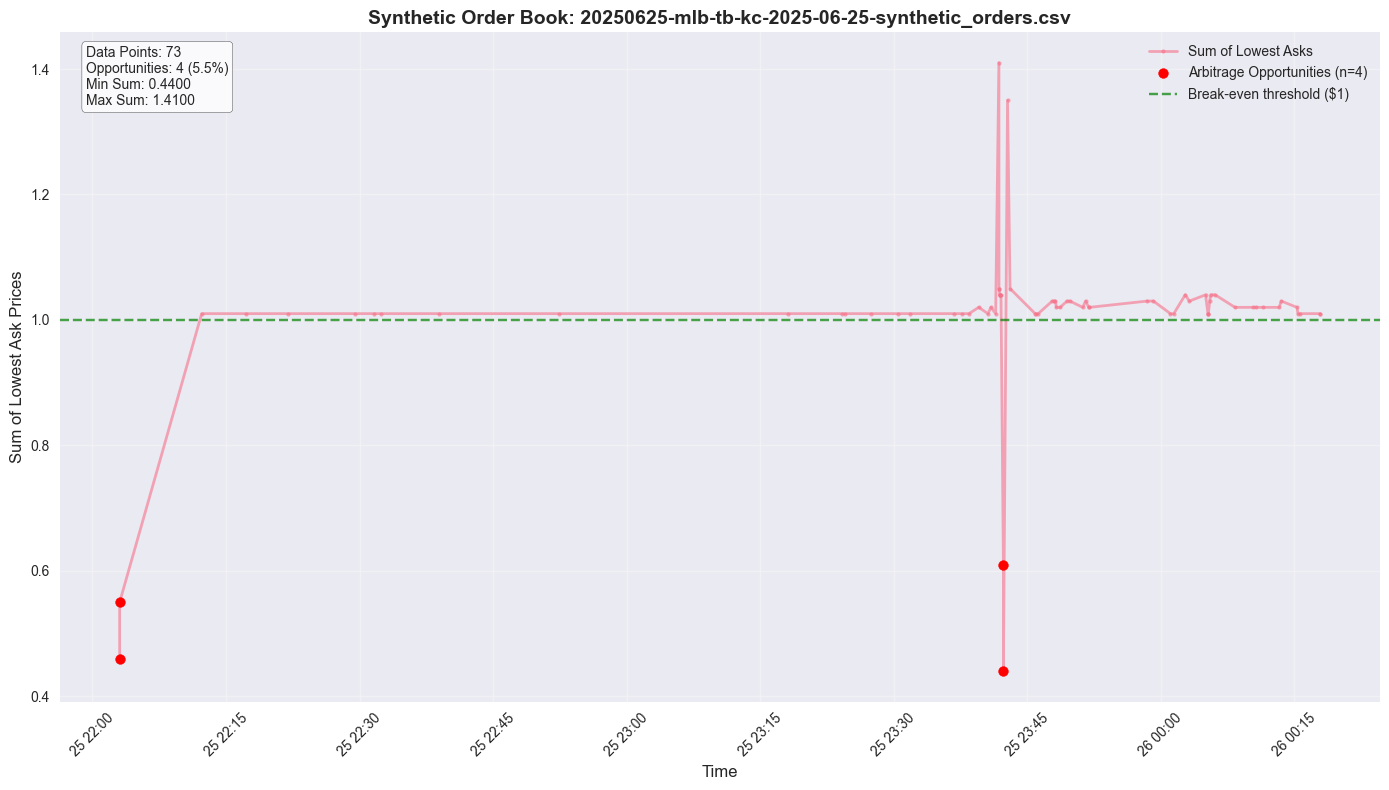


=== Visualization for 20250624-mlb-atl-nym-2025-06-24-synthetic_orders.csv ===


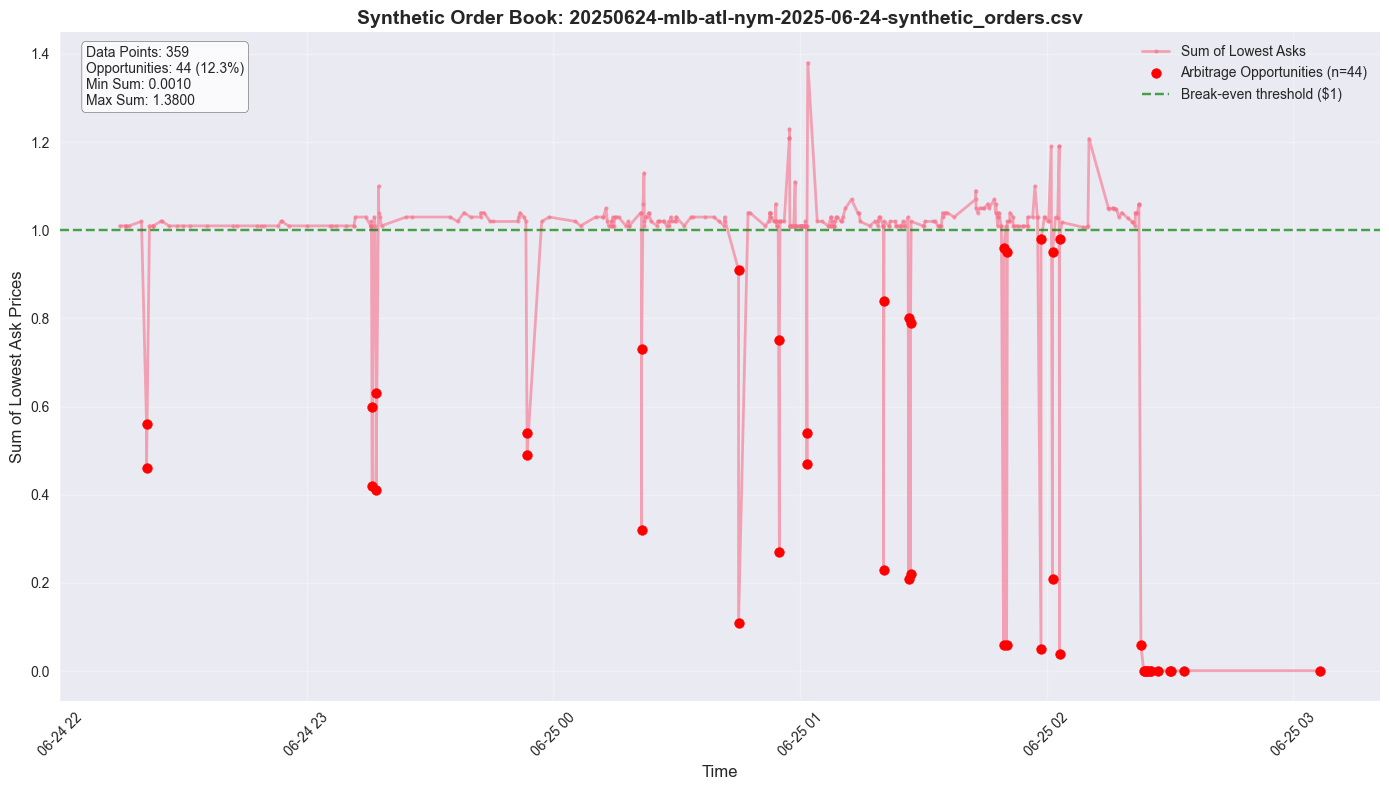


=== Visualization for 20250624-mlb-wsh-sd-2025-06-24-synthetic_orders.csv ===


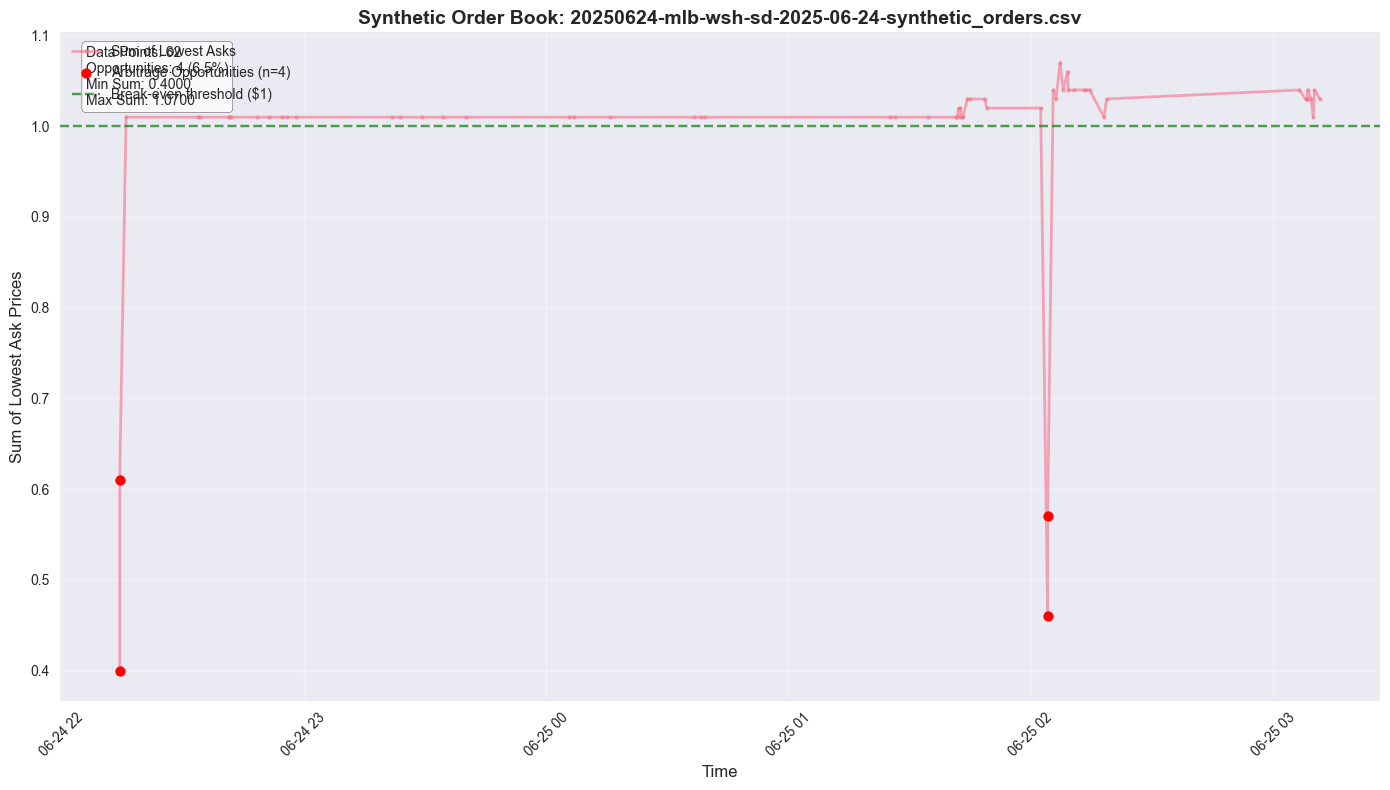


=== Visualization for 20250624-mlb-chc-stl-2025-06-24-synthetic_orders.csv ===


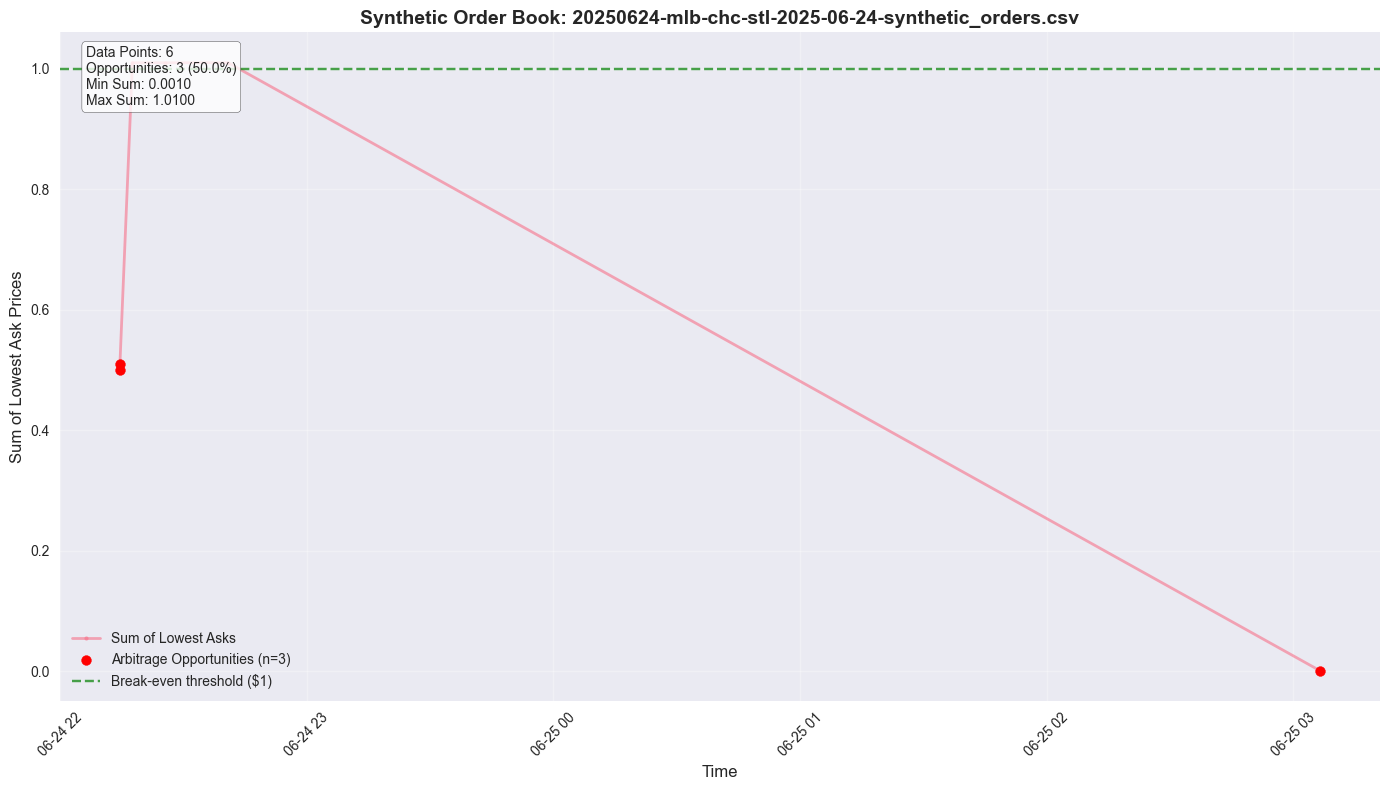


=== Visualization for 20250624-mlb-tex-bal-2025-06-24-synthetic_orders.csv ===


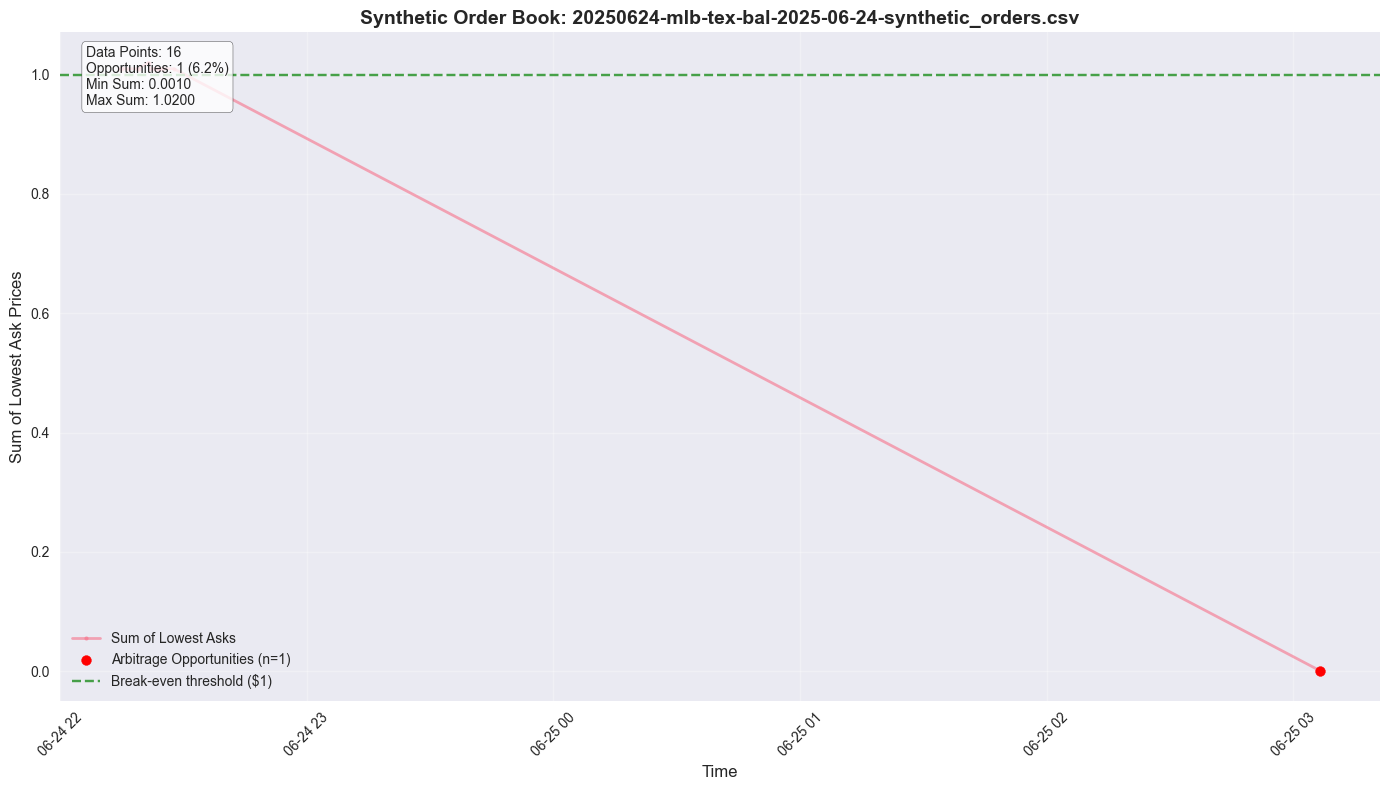

In [16]:
# Create individual plots for each synthetic order book file
for filename, result_df in order_book_results.items():
    if not result_df.empty:
        print(f"\n=== Visualization for {filename} ===")
        
        plt.figure(figsize=(14, 8))
        
        # Plot all data points
        plt.plot(result_df['datetime'], result_df['price_sum'], 
                 linewidth=2, marker='o', markersize=3, alpha=0.6, label='Sum of Lowest Asks')
        
        # Highlight opportunities (sum < 1.0) in red
        opportunities = result_df[result_df['price_sum'] < 1.0]
        if not opportunities.empty:
            plt.scatter(opportunities['datetime'], opportunities['price_sum'], 
                       color='red', s=50, zorder=5, label=f'Arbitrage Opportunities (n={len(opportunities)})')
        
        # Add horizontal line at y=1
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Break-even threshold ($1)')
        
        plt.title(f'Synthetic Order Book: {filename}', fontsize=14, fontweight='bold')
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Sum of Lowest Ask Prices', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add statistics text
        stats_text = f"""Data Points: {len(result_df)}
Opportunities: {len(opportunities)} ({len(opportunities)/len(result_df)*100:.1f}%)
Min Sum: {result_df['price_sum'].min():.4f}
Max Sum: {result_df['price_sum'].max():.4f}"""
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

## Comparison: Market Events vs Synthetic Order Book

Let's compare the arbitrage opportunities found in both data sources by overlaying the graphs.

In [17]:
# Find matching files between market events and synthetic order book
matching_games = []

for market_file in all_results.keys():
    # Extract game identifier from market events filename
    game_id = market_file.replace('-polymarket_market_events.csv', '')
    
    # Look for corresponding order book file
    order_book_file = f"{game_id}-order_book.csv"
    
    if order_book_file in order_book_results:
        matching_games.append((game_id, market_file, order_book_file))

print(f"Found {len(matching_games)} matching game pairs")
for game_id, market_file, order_book_file in matching_games:
    print(f"  - {game_id}")

# Create overlay plots for matching games
for game_id, market_file, order_book_file in matching_games[:3]:  # Show first 3 matches
    market_df = all_results[market_file]
    order_book_df = order_book_results[order_book_file]
    
    if not market_df.empty and not order_book_df.empty:
        plt.figure(figsize=(16, 10))
        
        # Plot market events data
        plt.plot(market_df['datetime'], market_df['price_sum'], 
                 linewidth=2, marker='o', markersize=4, alpha=0.7, 
                 label='Market Events (book events only)', color='blue')
        
        # Plot synthetic order book data
        plt.plot(order_book_df['datetime'], order_book_df['price_sum'], 
                 linewidth=2, marker='s', markersize=3, alpha=0.6, 
                 label='Synthetic Order Book', color='orange')
        
        # Highlight opportunities from both sources
        market_opps = market_df[market_df['price_sum'] < 1.0]
        order_book_opps = order_book_df[order_book_df['price_sum'] < 1.0]
        
        if not market_opps.empty:
            plt.scatter(market_opps['datetime'], market_opps['price_sum'], 
                       color='darkblue', s=80, zorder=5, marker='o',
                       label=f'Market Events Opportunities (n={len(market_opps)})')
        
        if not order_book_opps.empty:
            plt.scatter(order_book_opps['datetime'], order_book_opps['price_sum'], 
                       color='red', s=60, zorder=5, marker='s',
                       label=f'Order Book Opportunities (n={len(order_book_opps)})')
        
        # Add horizontal line at y=1
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, 
                   label='Break-even threshold ($1)')
        
        plt.title(f'Comparison: {game_id}', fontsize=16, fontweight='bold')
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Sum of Lowest Ask Prices', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add comparison statistics
        stats_text = f"""Market Events: {len(market_df)} points, {len(market_opps)} opportunities
Synthetic Order Book: {len(order_book_df)} points, {len(order_book_opps)} opportunities
Order Book captures {len(order_book_df)/len(market_df):.1f}x more data points"""
        
        plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='bottom', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

Found 0 matching game pairs


In [18]:
# Summary comparison statistics
print("=== OVERALL COMPARISON ===\n")

# Collect statistics for both data sources
market_stats = []
order_book_stats = []

for game_id, market_file, order_book_file in matching_games:
    market_df = all_results[market_file]
    order_book_df = order_book_results[order_book_file]
    
    if not market_df.empty and not order_book_df.empty:
        market_opps = market_df[market_df['price_sum'] < 1.0]
        order_book_opps = order_book_df[order_book_df['price_sum'] < 1.0]
        
        market_stats.append({
            'game': game_id,
            'data_points': len(market_df),
            'opportunities': len(market_opps),
            'opp_rate': len(market_opps) / len(market_df) * 100 if len(market_df) > 0 else 0
        })
        
        order_book_stats.append({
            'game': game_id,
            'data_points': len(order_book_df),
            'opportunities': len(order_book_opps),
            'opp_rate': len(order_book_opps) / len(order_book_df) * 100 if len(order_book_df) > 0 else 0
        })

if market_stats and order_book_stats:
    market_summary = pd.DataFrame(market_stats)
    order_book_summary = pd.DataFrame(order_book_stats)
    
    print("Market Events Summary:")
    print(f"  Total data points: {market_summary['data_points'].sum()}")
    print(f"  Total opportunities: {market_summary['opportunities'].sum()}")
    print(f"  Average opportunity rate: {market_summary['opp_rate'].mean():.1f}%")
    
    print("\nSynthetic Order Book Summary:")
    print(f"  Total data points: {order_book_summary['data_points'].sum()}")
    print(f"  Total opportunities: {order_book_summary['opportunities'].sum()}")
    print(f"  Average opportunity rate: {order_book_summary['opp_rate'].mean():.1f}%")
    
    print(f"\nData Coverage Improvement:")
    print(f"  Synthetic Order Book captures {order_book_summary['data_points'].sum() / market_summary['data_points'].sum():.1f}x more data points")
    print(f"  Synthetic Order Book finds {order_book_summary['opportunities'].sum() / market_summary['opportunities'].sum():.1f}x more opportunities")

=== OVERALL COMPARISON ===

